# **Using a singular model-structure to predict the data**


## Data Import

In [107]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Models
import tensorflow as tf
import keras

# Metrics
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error

from sklearn.model_selection import train_test_split

from utils import *

datasets_folder = './datasets'
figsize = (20,4)
verbosity = 0

metrics = [root_mean_squared_error, r2_score, mean_absolute_error, huber]

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [3]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())
agents = list(set(agent for station in stations for agent in pollution_data[station].keys()))

## Data Merging

- Traffic data is per-station, but it should be normalized globally. To do so we first merge the data, we apply normalization, and later use the date and the statino to merge the data with the pollutants.

In [4]:
merged_traffic_data = pd.concat(
    [df.assign(Station=key) for key, df in traffic_data.items()]
)
print(merged_traffic_data.resample('1h').max().isna().sum())
merged_traffic_data

Traffic_value    0
Station          0
dtype: int64


,Traffic_value,Station
Date,,
2019-01-01 00:00:00,27629.0,GIARDINI MARGHERITA
2019-01-01 01:00:00,44430.0,GIARDINI MARGHERITA
2019-01-01 02:00:00,40318.0,GIARDINI MARGHERITA
2019-01-01 03:00:00,25661.0,GIARDINI MARGHERITA
2019-01-01 04:00:00,15906.0,GIARDINI MARGHERITA
...,...,...
2024-12-31 19:00:00,19786.0,VIA CHIARINI
2024-12-31 20:00:00,16239.0,VIA CHIARINI
2024-12-31 21:00:00,7226.0,VIA CHIARINI


In [5]:
scaler = StandardScaler()
scaled_traffic_data = merged_traffic_data.copy()
scaled_traffic_data['Traffic_value'] = scaler.fit_transform(merged_traffic_data[['Traffic_value']])
scaled_traffic_data

,Traffic_value,Station
Date,,
2019-01-01 00:00:00,-0.366692,GIARDINI MARGHERITA
2019-01-01 01:00:00,0.111507,GIARDINI MARGHERITA
2019-01-01 02:00:00,-0.005531,GIARDINI MARGHERITA
2019-01-01 03:00:00,-0.422706,GIARDINI MARGHERITA
2019-01-01 04:00:00,-0.700359,GIARDINI MARGHERITA
...,...,...
2024-12-31 19:00:00,-0.589924,VIA CHIARINI
2024-12-31 20:00:00,-0.690881,VIA CHIARINI
2024-12-31 21:00:00,-0.947414,VIA CHIARINI


- weather data is global, we only have to normalize it. Since that it is a singular df, we add the date encodings to this dataframe for semplicity. Encodings seemed to be very helpful with singular models.

In [126]:
scaler = StandardScaler()
encoded_weather_data = encode_date_index(weather_data.copy(), method='radial_months-sin-cos_days_hours')
scaled_weather_data = encoded_weather_data.copy()
scaled_weather_data[:] = scaler.fit_transform(scaled_weather_data)
print(scaled_weather_data.resample('1h').max().isna().sum())
scaled_weather_data

TAVG            0
PREC            0
RHAVG           0
RAD             0
W_SCAL_INT      0
W_VEC_DIR       0
LEAFW           0
hour_sin        0
hour_cos        0
day_sin         0
day_cos         0
month_rbf_1     0
month_rbf_2     0
month_rbf_3     0
month_rbf_4     0
month_rbf_5     0
month_rbf_6     0
month_rbf_7     0
month_rbf_8     0
month_rbf_9     0
month_rbf_10    0
month_rbf_11    0
month_rbf_12    0
dtype: int64


,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,day_sin,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 03:00:00,-1.816457,-0.136824,1.278379,-0.661589,-1.308868,-0.171911,-0.465156,1.000000e+00,1.000000,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 04:00:00,-1.746206,-0.136824,1.020722,-0.661589,-1.308868,-0.357363,-0.465156,1.224745e+00,0.707107,2.846791e-01,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,-1.113941,-0.136824,0.743245,-0.661589,-0.260449,0.441767,-0.465156,-1.366025e+00,0.366025,-3.387421e-16,...,-0.385296,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386058,-0.386438,0.110871,3.229888
2024-12-31 20:00:00,-0.985147,-0.136824,0.525228,-0.661589,0.236170,0.355222,-0.465156,-1.224745e+00,0.707107,-3.387421e-16,...,-0.385296,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386058,-0.386438,0.110871,3.229888
2024-12-31 21:00:00,-1.055398,-0.136824,0.629282,-0.661589,0.236170,0.345107,-0.465156,-1.000000e+00,1.000000,-3.387421e-16,...,-0.385296,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386058,-0.386438,0.110871,3.229888


- The agent values should be normalized to avoid exploding losses.

In [ ]:
for station in stations:
    for agent, d_agent_values in pollution_data[station].items():
        num = d_agent_values.isna().sum()['Agent_value']
        if num > 0:
            print(f'Found {num} nan values in {agent}-{station}')
        pollution_data[station][agent] = d_agent_values.dropna()


In [ ]:
for station in stations:
    print(station)
    for agent, d_agent_values in pollution_data[station].items():
        print(f'{agent}, mean:{d_agent_values.mean().values}, std:{d_agent_values.std().values}')

GIARDINI MARGHERITA
NO2, mean:[-0.41819203], std:[0.67688521]
O3, mean:[0.0611332], std:[0.9894924]
PM10, mean:[-0.07123814], std:[0.98838028]
PM2.5, mean:[-0.06631884], std:[0.98888645]
PORTA SAN FELICE
C6H6, mean:[-3.71905419e-17], std:[1.]
CO, mean:[3.57996147e-16], std:[1.]
NO2, mean:[0.79580048], std:[1.03758237]
PM10, mean:[0.13899262], std:[1.05475162]
PM2.5, mean:[0.06539044], std:[1.00679905]
VIA CHIARINI
NO2, mean:[-0.37737511], std:[0.71756737]
O3, mean:[-0.06134909], std:[1.00671928]
PM10, mean:[-0.06973779], std:[0.93854246]


Each agent should be normalized across all station, since  that the model heads will be per agent and not per station-agent.

In [129]:
agent_distributions = {} # dict agent:tuple[mean, std]

for agent in agents:
    aux = pd.concat([pollution_data[station][agent] for station in stations if agent in pollution_data[station]])
    agent_distributions[agent] = (aux.mean().values[0], aux.std().values[0])

agent_distributions

{'PM10': (-3.35161667811368e-17, 1.0),
 'NO2': (-8.234660293107883e-17, 1.0),
 'C6H6': (-3.7190541883988067e-17, 0.9999999999999999),
 'PM2.5': (-6.678033230828009e-17, 1.0),
 'CO': (3.579961468350639e-16, 1.0),
 'O3': (-4.4041620749459014e-18, 1.0)}

In [130]:
normalized_pollution_data = pollution_data.copy()

for station in stations:
    for agent in normalized_pollution_data[station]:
        normalized_pollution_data[station][agent] = (normalized_pollution_data[station][agent] - agent_distributions[agent][0]) / agent_distributions[agent][1]

for agent in agents:
    aux = pd.concat([normalized_pollution_data[station][agent] for station in stations if agent in normalized_pollution_data[station]])
    print(agent, round(aux.mean().values[0], 2), round(aux.std().values[0], 2))

PM10 -0.0 1.0
NO2 -0.0 1.0
C6H6 -0.0 1.0
PM2.5 -0.0 1.0
CO -0.0 1.0
O3 -0.0 1.0


- We can now divide the traffic per station, merge them with the weather and create the input sequences. For every agent of the same station, the input data is the same.
    
    We might also want to consider adding new informations, like the date encodings and so on...

In [131]:
station_data = {
    station: pd.merge(
        scaled_traffic_data[scaled_traffic_data['Station'] == station].drop(columns=['Station']),
        scaled_weather_data,
        left_index=True,
        right_index=True
    )
    for station in stations
}
for station in station_data:
    display(station, station_data[station].resample('1h').max().isna().sum(), station_data[station].head(3))

'GIARDINI MARGHERITA'

Traffic_value    0
TAVG             0
PREC             0
RHAVG            0
RAD              0
W_SCAL_INT       0
W_VEC_DIR        0
LEAFW            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
month_rbf_1      0
month_rbf_2      0
month_rbf_3      0
month_rbf_4      0
month_rbf_5      0
month_rbf_6      0
month_rbf_7      0
month_rbf_8      0
month_rbf_9      0
month_rbf_10     0
month_rbf_11     0
month_rbf_12     0
dtype: int64

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.366692,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,0.111507,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,-0.005531,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714


'PORTA SAN FELICE'

Traffic_value    0
TAVG             0
PREC             0
RHAVG            0
RAD              0
W_SCAL_INT       0
W_VEC_DIR        0
LEAFW            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
month_rbf_1      0
month_rbf_2      0
month_rbf_3      0
month_rbf_4      0
month_rbf_5      0
month_rbf_6      0
month_rbf_7      0
month_rbf_8      0
month_rbf_9      0
month_rbf_10     0
month_rbf_11     0
month_rbf_12     0
dtype: int64

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.011177,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,0.599669,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,0.316324,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714


'VIA CHIARINI'

Traffic_value    0
TAVG             0
PREC             0
RHAVG            0
RAD              0
W_SCAL_INT       0
W_VEC_DIR        0
LEAFW            0
hour_sin         0
hour_cos         0
day_sin          0
day_cos          0
month_rbf_1      0
month_rbf_2      0
month_rbf_3      0
month_rbf_4      0
month_rbf_5      0
month_rbf_6      0
month_rbf_7      0
month_rbf_8      0
month_rbf_9      0
month_rbf_10     0
month_rbf_11     0
month_rbf_12     0
dtype: int64

,Traffic_value,TAVG,PREC,RHAVG,RAD,W_SCAL_INT,W_VEC_DIR,LEAFW,hour_sin,hour_cos,...,month_rbf_3,month_rbf_4,month_rbf_5,month_rbf_6,month_rbf_7,month_rbf_8,month_rbf_9,month_rbf_10,month_rbf_11,month_rbf_12
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,-0.913856,-1.746206,-0.136824,1.318018,-0.661589,-1.419227,0.045012,-0.465156,2.635922e-17,1.414214,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 01:00:00,-0.724523,-1.828166,-0.136824,1.382433,-0.661589,-1.419227,0.846389,-0.465156,3.660254e-01,1.366025,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714
2019-01-01 02:00:00,-0.787369,-1.781331,-0.136824,1.288289,-0.661589,-1.088148,-0.523708,-0.465156,7.071068e-01,1.224745,...,-0.384082,-0.386048,-0.387652,-0.386059,-0.389063,-0.389063,-0.386059,-0.387652,-0.384827,0.100714


Sequences should also be indexed with the date of the last element, so that merging with the agent will be easier. To do so, we simply use one variable for the sequences and one for the dates.

In [132]:
hourly_time_steps = 3
daily_time_steps = 24

In [133]:
station_sliding_windows = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station],
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=hourly_time_steps
    )
    dates = dates.index.tolist()
    station_sliding_windows[station] = sequences, dates

In [142]:
station_sequences = {}
for station in station_data:
    sequences, dates = create_sequences(
        station_data[station].drop(columns=['hour_sin', 'hour_cos']),
        pd.Series(station_data[station].index, index=station_data[station].index),
        time_steps=daily_time_steps,
        sliding_window=False
    ) 
    station_sequences[station] = sequences, dates

- At this point we should create the actual train data composed of sequence + agentID and the target values. We could of course create an huge dataset and directly use it, but I dont know if it is too big and with too many repeated values (sequences are repeated for each agent and each sequence share some rows).

    <!-- For now, I simply try to make a dataset made of `in=(station_date, sequence)`, `x=(station_date, agent)` and `y=(target)`. I don't want the model to learn station and agent.  -->
    The model should be able to take a batch and use the dates to access the sequences, create the embeddings, and use the agent to predict the concentration using the correct classification head. Since that we have to map a dict would be suitable for fast data access.

- Also, at this point we have to divide hourly and daily agents because the embedding we are trying to create for the stations can be quite different. For example if we have to predict an hourly pollutant, we might want to use 3/5 prev. hours. For daily agents instead, the whole 24 hours might be helpful.

In [193]:
def create_key(station, date):
    return (station+' '+str(date)).replace(' ','_')


def sort_lists(timestamps, *iterables):
    combined = zip(timestamps, *iterables)
    combined_sorted = sorted(combined, key=lambda x: x[0])
    unpacked = zip(*combined_sorted)
    # next(unpacked)  # skip timestamps
    return tuple(map(list, unpacked))


hourly_input_data = {}
daily_input_data = {}
for station in station_sequences:
    for seq, date in zip(station_sliding_windows[station][0], station_sliding_windows[station][1]):
        hourly_input_data[create_key(station, date)] = seq
    for seq, date in zip(station_sequences[station][0], station_sequences[station][1]):
        daily_input_data[create_key(station, date)] = seq

h_dates = []
h_keys = []
h_agentsIDs = []
h_values = []
h_stationsIDs = []

d_dates = []
d_keys = []
d_agentsIDs = []
d_values = []
d_stationsIDs = []

for station in pollution_data:
    for agent in pollution_data[station]:
        for target, date in zip(pollution_data[station][agent]['Agent_value'], pollution_data[station][agent].index):
            if agent in ('PM10', 'PM2.5'):
                d_dates.append(date)
                d_keys.append(create_key(station, date))
                d_agentsIDs.append(agents.index(agent))
                d_values.append(target)
                d_stationsIDs.append(stations.index(station))
            else: 
                h_dates.append(date)
                h_keys.append(create_key(station, date))
                h_agentsIDs.append(agents.index(agent))
                h_values.append(target)
                h_stationsIDs.append(stations.index(station))

# sort the arrays using the dates
h_dates, h_keys, h_agentsIDs, h_values, h_stationsIDs = sort_lists(h_dates, h_keys, h_agentsIDs, h_values, h_stationsIDs)
d_dates, d_keys, d_agentsIDs, d_values, d_stationsIDs = sort_lists(d_dates, d_keys, d_agentsIDs, d_values, d_stationsIDs)

In [194]:
h_dates[:5]

[Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-02 00:00:00')]

In [144]:
print("NaN in h_values:", np.isnan(h_values).any())
print("NaN in d_values:", np.isnan(d_values).any())

NaN in h_values: False
NaN in d_values: False


## Dataset

- The model will use a TensorFlow DataSet for better something (something's gotta be better right?).

Remove rows if there is no input data

In [ ]:
valid_h_indices = [i for i, k in enumerate(h_keys) if k in hourly_input_data]
h_keys          = [h_keys[i]        for i in valid_h_indices]
h_agentsIDs     = [h_agentsIDs[i]   for i in valid_h_indices]
h_values        = [h_values[i]      for i in valid_h_indices]
h_dates         = [h_dates[i]       for i in valid_h_indices]
h_stationsIDs   = [h_stationsIDs[i] for i in valid_h_indices]

valid_d_indices = [i for i, k in enumerate(d_keys) if k in daily_input_data]
d_keys          = [d_keys[i]        for i in valid_d_indices]
d_agentsIDs     = [d_agentsIDs[i]   for i in valid_d_indices]
d_values        = [d_values[i]      for i in valid_d_indices]
d_dates         = [d_dates[i]       for i in valid_d_indices]
d_stationsIDs   = [d_stationsIDs[i] for i in valid_d_indices]

In [146]:
def make_tf_loader(data_dict, time_steps, features):
    def _load_sample(key, _agent_id, val, _station_id):
        k = key.numpy().decode("utf-8")
        seq = data_dict[k].astype("float32")   # [time_steps, features]
        return seq, _agent_id, val, _station_id

    def _tf_load(key, _agent_id, val, _station_id):
        seq, agent_id, value, station_id = tf.py_function(
            func=_load_sample,
            inp=[key, _agent_id, val, _station_id],
            Tout=[tf.float32, tf.int32, tf.float32, tf.int32]
        )
        seq.set_shape([time_steps, features])
        agent_id.set_shape([])
        value.set_shape([])
        station_id.set_shape([])  # Set shape for the new element
        return seq, agent_id, value, station_id

    return _tf_load


hourly_input_shape = (list(hourly_input_data.values())[0]).shape
daily_input_shape =  (list(daily_input_data.values())[0]).shape
print(hourly_input_shape, daily_input_shape)
h_loader = make_tf_loader(hourly_input_data, *hourly_input_shape)
d_loader = make_tf_loader(daily_input_data, *daily_input_shape)

hourly_dataset = tf.data.Dataset.from_tensor_slices((h_keys, h_agentsIDs, h_values, h_stationsIDs))
daily_dataset = tf.data.Dataset.from_tensor_slices((d_keys, d_agentsIDs, d_values, d_stationsIDs))

hourly_dataset = hourly_dataset.map(h_loader, num_parallel_calls=tf.data.AUTOTUNE)
daily_dataset = daily_dataset.map(d_loader, num_parallel_calls=tf.data.AUTOTUNE)

(3, 24) (24, 22)


### Model

- As we said earlier, the model should be able to use the station and date to access the actual training sequences.

In [ ]:
class MultiAgentModel(tf.keras.Model):
    def __init__(
        self,
        input_shape,
        task_ids,  # e.g. [2, 5]
        lstm_units=(128, 64),
        head_hidden_units=(32,),
    ):
        super().__init__()
        self.task_ids = tf.constant(task_ids, dtype=tf.int32)
        self.task_id_to_index = {int(tid): i for i, tid in enumerate(task_ids)}  # id → index

        self.encoder = tf.keras.Sequential(name="encoder")
        self.encoder.add(tf.keras.layers.Masking(input_shape=input_shape))
        for i, units in enumerate(lstm_units):
            self.encoder.add(tf.keras.layers.LSTM(
                units, return_sequences=(i < len(lstm_units) - 1), name=f"lstm_{i}"
            ))

        self.heads = []
        for tid in task_ids:
            head = tf.keras.Sequential(name=f"head_agent_{tid}")
            head.add(tf.keras.layers.InputLayer(input_shape=(lstm_units[-1],)))
            for head_hidden_unit in head_hidden_units:
                head.add(tf.keras.layers.Dense(head_hidden_unit, activation="relu"))
            head.add(tf.keras.layers.Dense(1))
            self.heads.append(head)

    def call(self, inputs, training=False):
        x, task_ids = inputs  # x: [B, T, F], task_ids: [B]

        # 1. Encode sequence
        embs = self.encoder(x, training=training)  # [B, D]

        # 2. Map task_ids → head indices
        lookup_table = tf.lookup.StaticHashTable(
            tf.lookup.KeyValueTensorInitializer(
                keys=tf.constant(list(self.task_id_to_index.keys()), dtype=tf.int32),
                values=tf.constant(list(self.task_id_to_index.values()), dtype=tf.int32),
            ),
            default_value=-1
        )
        head_indices = lookup_table.lookup(task_ids)  # [B]

        # 3. Apply each head using tf.map_fn + tf.switch_case
        def apply_head(i):
            emb_i, head_idx = i

            def case_fn(j):
                return lambda: self.heads[j](tf.expand_dims(emb_i, axis=0), training=training)

            # Build cases for switch_case
            branches = [case_fn(j) for j in range(len(self.heads))]

            out = tf.switch_case(head_idx, branch_fns=branches)
            return out[0]  # [1] → scalar

        preds = tf.map_fn(
            apply_head,
            (embs, head_indices),
            fn_output_signature=tf.TensorSpec(shape=(1,), dtype=tf.float32)
        )

        return tf.squeeze(preds, axis=1)  # [B]

    def train_step(self, data):
        x_batch, task_ids, y_batch, station_ids = data
        with tf.GradientTape() as tape:
            preds = self((x_batch, task_ids), training=True)
            loss = self.compiled_loss(y_batch, preds)
        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x_batch, task_ids, y_batch, station_ids = data
        preds = self((x_batch, task_ids), training=False)
        loss = self.compiled_loss(y_batch, preds)
        self.compiled_metrics.update_state(y_batch, preds)
        return {m.name: m.result() for m in self.metrics}


## Training

### Daily

In [209]:
d_model.save_weights('./multi-agent-models/daily_emb_64-64-64_64-32.h5')

In [ ]:
d_train, d_val, d_test = split_dataset(daily_dataset, batch_size=32)

Epoch 1/100
253/253 [==============================] - 23s 46ms/step - loss: 0.6919 - mae: 0.5825 - val_loss: 0.6110 - val_mae: 0.5546 - lr: 0.0100
Epoch 2/100
253/253 [==============================] - 11s 36ms/step - loss: 0.6135 - mae: 0.5422 - val_loss: 0.6887 - val_mae: 0.6122 - lr: 0.0100
Epoch 3/100
253/253 [==============================] - 11s 36ms/step - loss: 0.5301 - mae: 0.5058 - val_loss: 0.4801 - val_mae: 0.4880 - lr: 0.0100
Epoch 4/100
253/253 [==============================] - 12s 39ms/step - loss: 0.5017 - mae: 0.4884 - val_loss: 0.6510 - val_mae: 0.5073 - lr: 0.0100
Epoch 5/100
253/253 [==============================] - 12s 39ms/step - loss: 0.5054 - mae: 0.4888 - val_loss: 0.4604 - val_mae: 0.4497 - lr: 0.0100
Epoch 6/100
253/253 [==============================] - 13s 43ms/step - loss: 0.4729 - mae: 0.4744 - val_loss: 0.4804 - val_mae: 0.4670 - lr: 0.0100
Epoch 7/100
253/253 [==============================] - 12s 38ms/step - loss: 0.4336 - mae: 0.4558 - val_loss: 0.

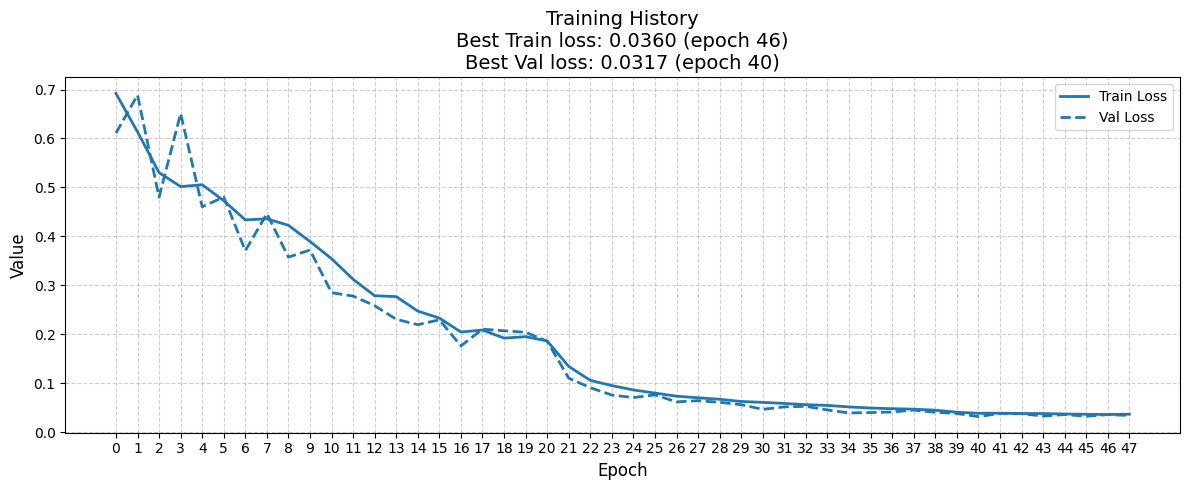

In [187]:
d_model = MultiAgentModel(
    input_shape=daily_input_shape,
    task_ids=[agents.index(agent) for agent in ('PM10','PM2.5')],
    lstm_units=(64, 64, 64),
    head_hidden_units=(64, 32),
)

d_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss="mse",       # mean squared error for regression
    metrics=["mae"],  # mean absolute error
    weighted_metrics=[]
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=7,
        restore_best_weights=True
    )
]

set_random_seed() # mi sa che non va
d_hist = d_model.fit(
    x=d_train,
    validation_data=d_val,
    epochs=100,
    callbacks=callbacks
)
plot_history(d_hist)

In [188]:
d_model.summary()

Model: "multi_agent_model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 64)                88320     
                                                                 
 head_agent_0 (Sequential)   (None, 1)                 6273      
                                                                 
 head_agent_3 (Sequential)   (None, 1)                 6273      
                                                                 
Total params: 100,866
Trainable params: 100,866
Non-trainable params: 0
_________________________________________________________________


In [ ]:
d_results = d_model.predict(d_test.map(lambda x, a, v, s: ((x, a),))) # only pass sequence and agent id

50/50 [==============================] - 3s 9ms/step


In [ ]:
d_agent_values = {}
i = 0

for _, agent_ids, targets, station_ids in d_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s in zip(agent_ids, targets, station_ids):

        if s not in d_agent_values:
            d_agent_values[s] = {}
        if a not in d_agent_values[s]:
            d_agent_values[s][a] = {
                'true': [],
                'pred': []
            }
        d_agent_values[s][a]['true'].append(t)
        d_agent_values[s][a]['pred'].append(d_results[i])
        i+=1

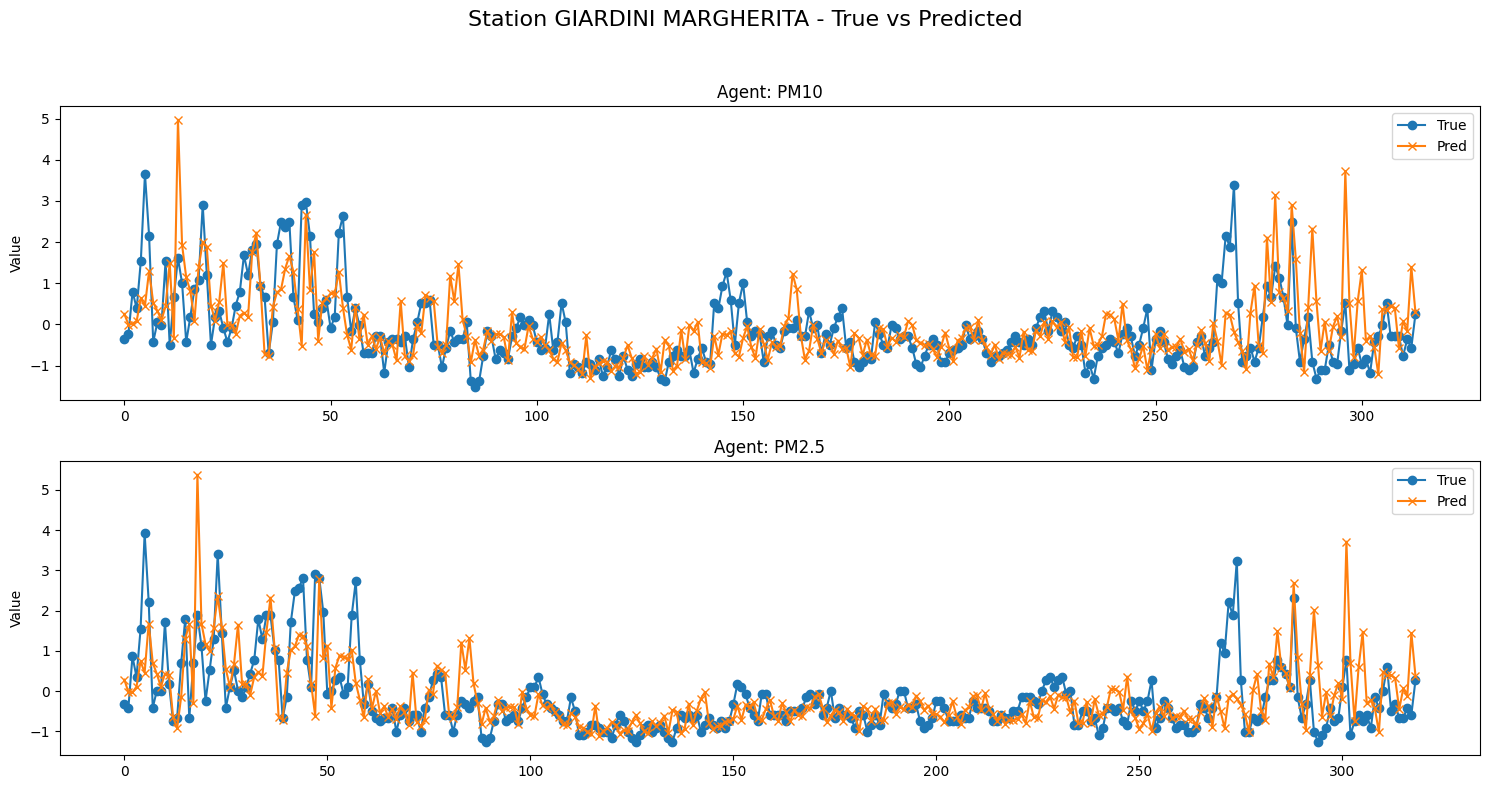

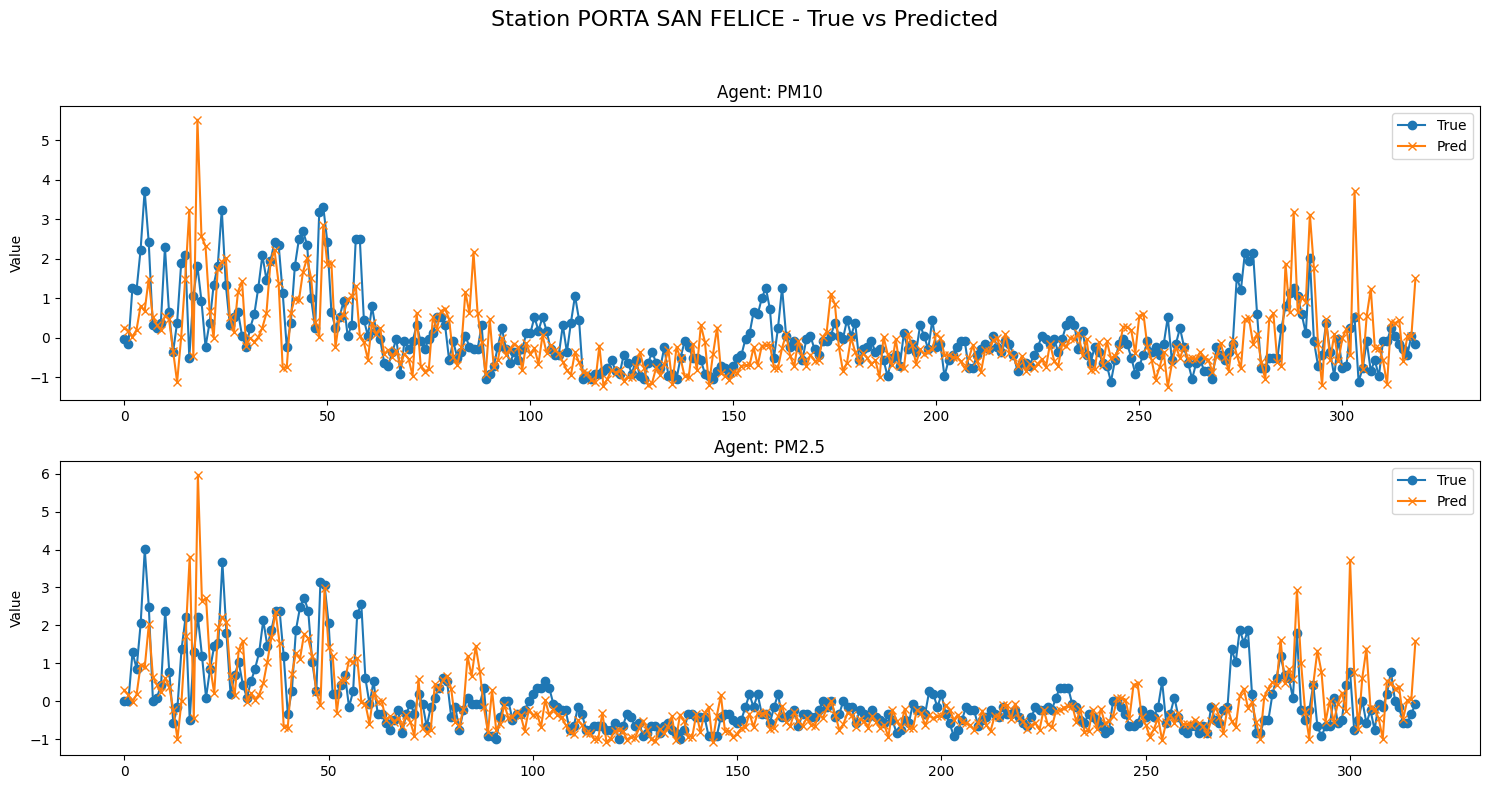

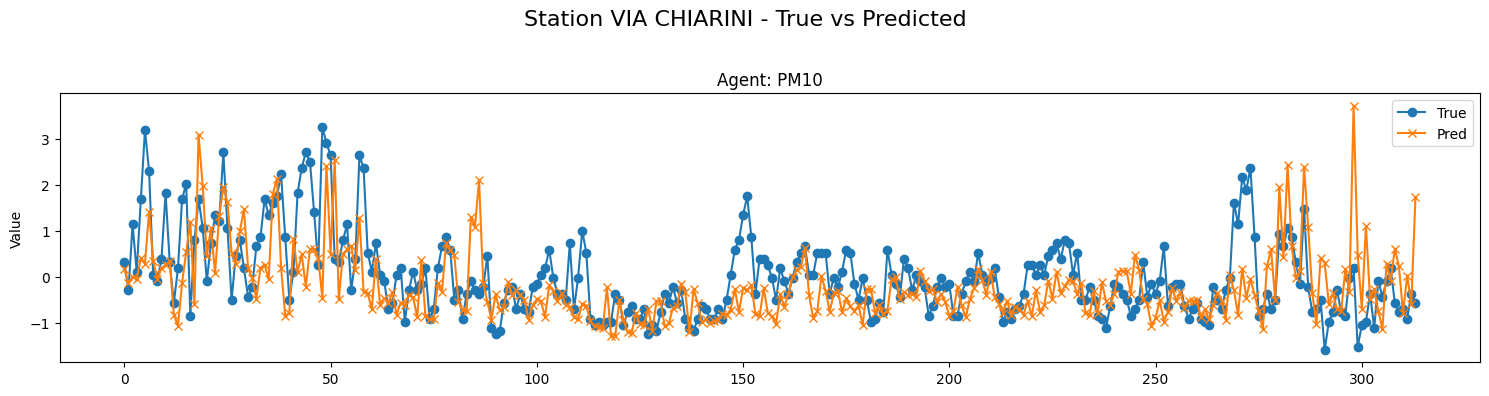

In [ ]:
plot_predictions(d_agent_values, stations, agents, agent_distributions)

### Hourly

In [208]:
h_model.save_weights('./multi-agent-models/hourly_emb_64-64-64_64-32.h5')

In [ ]:
h_train, h_val, h_test = split_dataset(hourly_dataset, batch_size=32)

Epoch 1/20
8572/8572 [==============================] - 237s 20ms/step - loss: 0.3569 - mae: 0.4253 - val_loss: 0.3285 - val_mae: 0.3973 - lr: 0.0100
Epoch 2/20
8572/8572 [==============================] - 231s 20ms/step - loss: 0.3170 - mae: 0.3972 - val_loss: 0.3266 - val_mae: 0.4060 - lr: 0.0100
Epoch 3/20
8572/8572 [==============================] - 234s 20ms/step - loss: 0.3048 - mae: 0.3901 - val_loss: 0.3058 - val_mae: 0.3819 - lr: 0.0100
Epoch 4/20
8572/8572 [==============================] - 232s 20ms/step - loss: 0.2997 - mae: 0.3850 - val_loss: 0.3088 - val_mae: 0.3798 - lr: 0.0100
Epoch 5/20
8572/8572 [==============================] - 240s 20ms/step - loss: 0.2956 - mae: 0.3818 - val_loss: 0.2992 - val_mae: 0.3731 - lr: 0.0100
Epoch 6/20
8572/8572 [==============================] - 232s 20ms/step - loss: 0.2923 - mae: 0.3796 - val_loss: 0.2998 - val_mae: 0.3871 - lr: 0.0100
Epoch 7/20
8572/8572 [==============================] - 234s 20ms/step - loss: 0.2882 - mae: 0.3776 

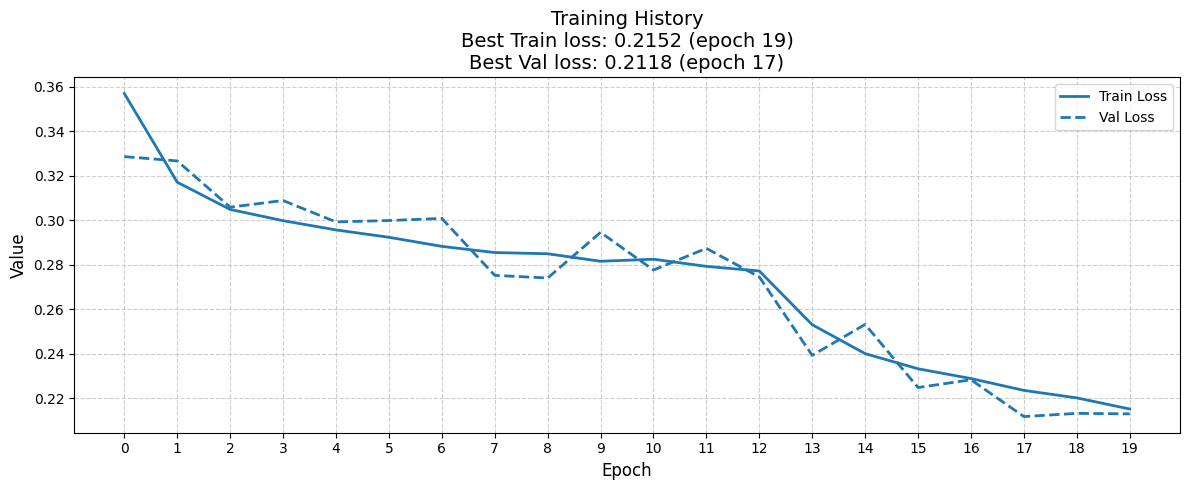

In [197]:
h_model = MultiAgentModel(
    input_shape=hourly_input_shape,
    task_ids=[agents.index(agent) for agent in agents if agent not in ('PM10','PM2.5')],
    lstm_units=(64, 64, 64),
    head_hidden_units=(64, 32),
)

h_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-2),
    loss="mse",       # mean squared error for regression
    metrics=["mae"],  # mean absolute error
    weighted_metrics=[]
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        factor=0.1,
        patience=4,
        min_lr=1e-7,
        verbose=1
    ),
    # keras.callbacks.EarlyStopping(
    #     monitor='val_loss',
    #     mode='min',
    #     patience=7,
    #     restore_best_weights=True
    # )
]

set_random_seed() # mi sa che non va
h_hist = h_model.fit(
    x=h_train,
    validation_data=h_val,
    epochs=20,
    callbacks=callbacks
)
plot_history(h_hist)

In [198]:
h_model.summary()

Model: "multi_agent_model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 64)                88832     
                                                                 
 head_agent_1 (Sequential)   (None, 1)                 6273      
                                                                 
 head_agent_2 (Sequential)   (None, 1)                 6273      
                                                                 
 head_agent_4 (Sequential)   (None, 1)                 6273      
                                                                 
 head_agent_5 (Sequential)   (None, 1)                 6273      
                                                                 
Total params: 113,924
Trainable params: 113,924
Non-trainable params: 0
_________________________________________________________________


In [199]:
h_results = h_model.predict(h_test.map(lambda x, a, v, s: ((x, a),))) # only pass sequence and agent id

1681/1681 [==============================] - 14s 7ms/step


In [201]:
h_agent_values = {}
i = 0

for _, agent_ids, targets, station_ids in h_test:
    agent_ids = agent_ids.numpy()
    targets = targets.numpy()
    station_ids = station_ids.numpy()

    for a, t, s in zip(agent_ids, targets, station_ids):

        if s not in h_agent_values:
            h_agent_values[s] = {}
        if a not in h_agent_values[s]:
            h_agent_values[s][a] = {
                'true': [],
                'pred': []
            }
        h_agent_values[s][a]['true'].append(t)
        h_agent_values[s][a]['pred'].append(h_results[i])
        i+=1

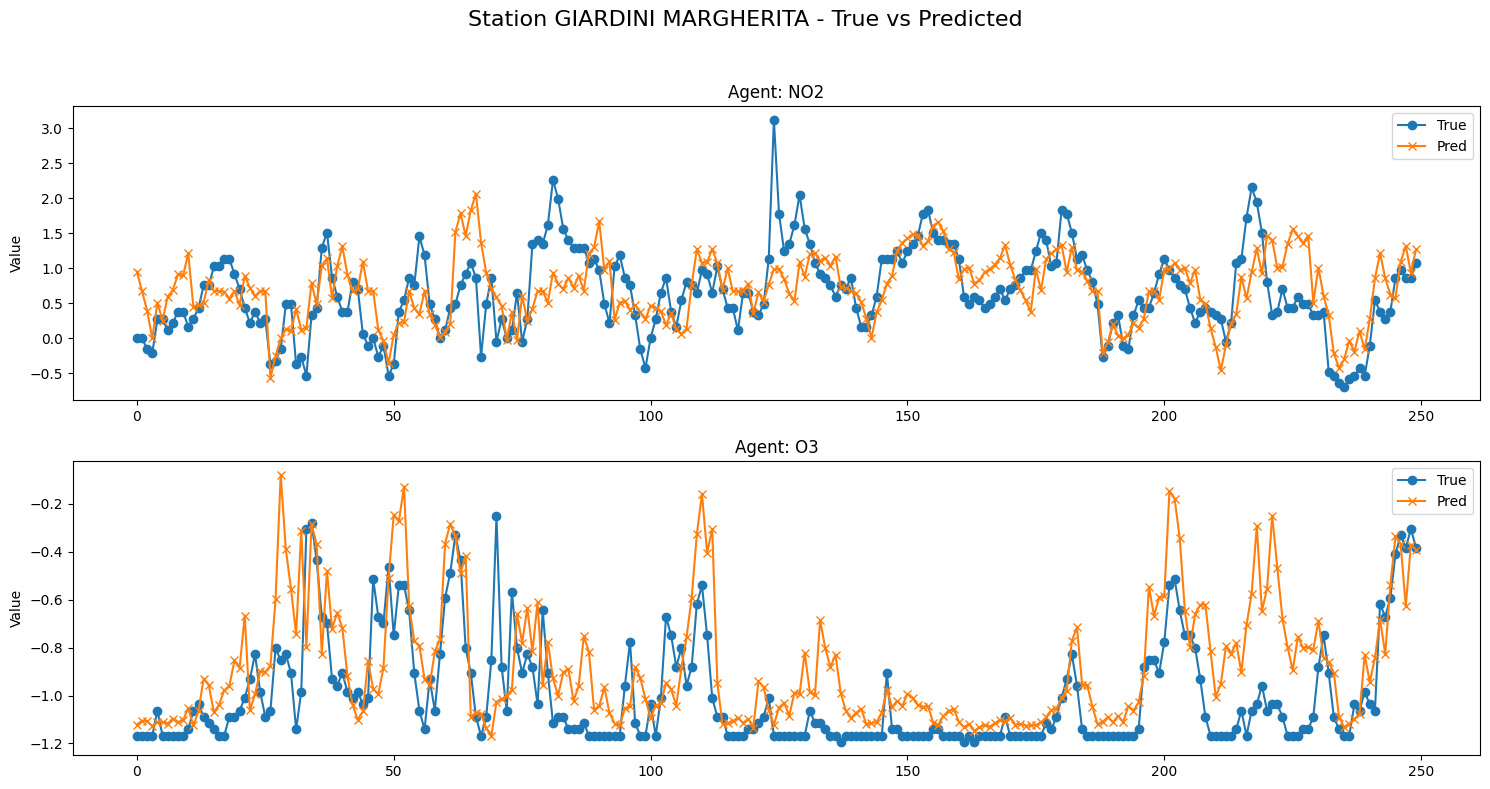

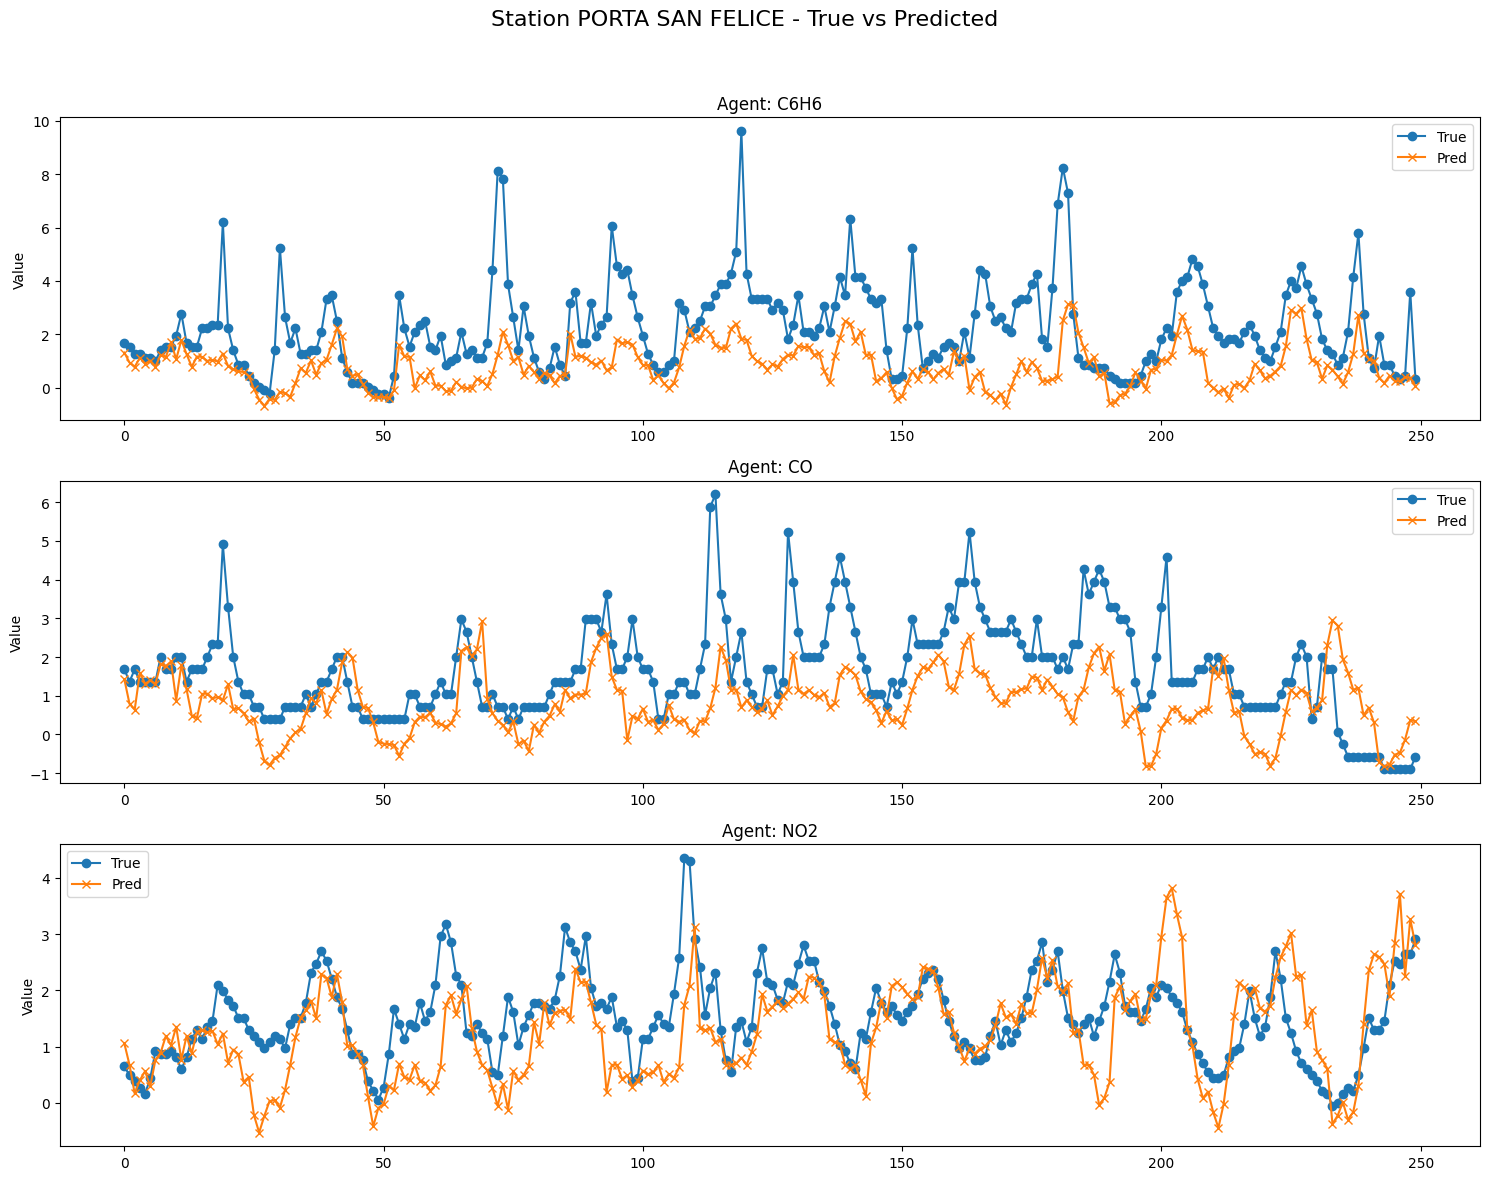

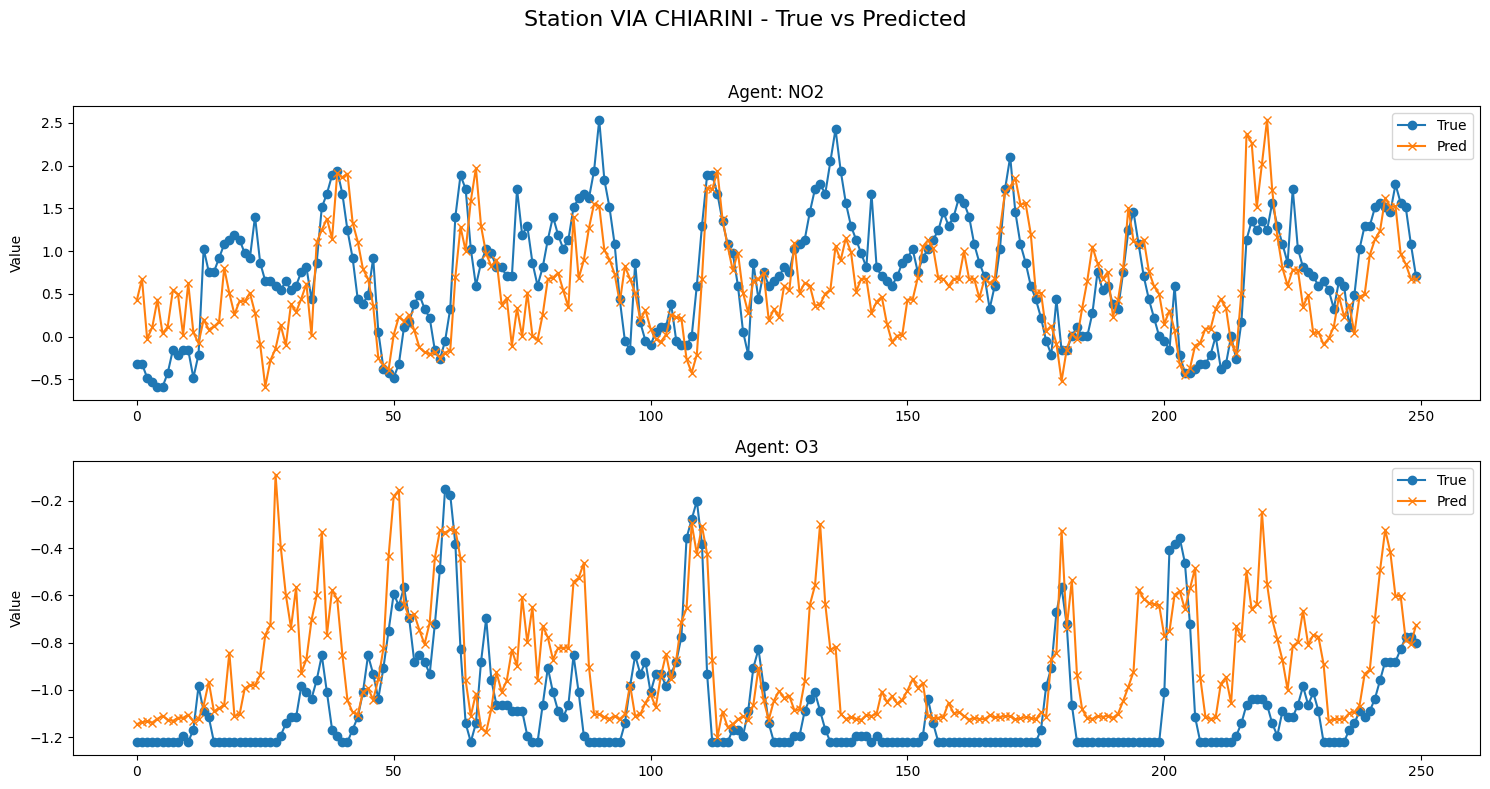

In [206]:
plot_predictions(h_agent_values, stations, agents, agent_distributions)